# Summary

    - This notebook loads set of credit transactions data and does the following
        - Identifies outlier transactions and visualizes them.
        - Plots matrix of important features
        - Checks accuracy of the fit model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
%matplotlib inline

## Load & Analyse Data

    - Check for missing values
    - Check if classes are imbalanced
    - Check if there is any relation b/w Time & Amount with a Fraudelent transaction 

C:\MachineLearning\anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\MachineLearning\anaconda\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


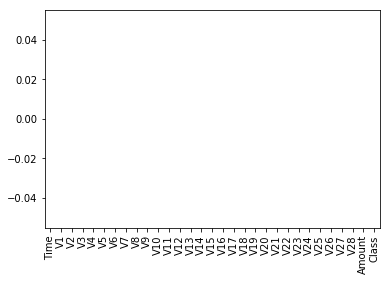

In [2]:
# load data file
data = pd.read_csv('CreditCard.csv')

labels = data.iloc[:,-1]
data_without_class = data.iloc[:,0:30]

scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data_without_class),columns = data_without_class.columns)
data['Class'] = labels

# check if any feature has missing values
data.isnull().sum().plot(kind='bar')

#Conclusion - No feature has missing value.

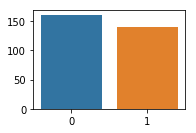

In [3]:
# Check if classes are imbalanced - i.e. if the ration of fraud and normal transactions is skewed

plt.plot([1,2,3])
plt.subplot(221)
class_counts = data['Class'].value_counts()
sns.barplot(class_counts.index, class_counts.values)

#Conclusion - There are roughly same number of Fraud & Normal Transactions

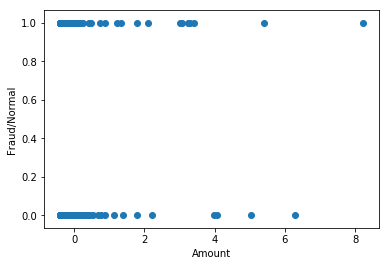

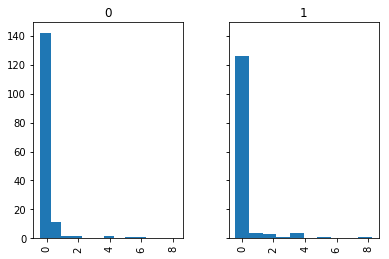

In [4]:
# Check if Fraud transactions appear for some specific Amount
plt.scatter(data['Amount'], data['Class'])
plt.xlabel('Amount')
plt.ylabel('Fraud/Normal')

data['Amount'].hist(by=data['Class'], sharex=True, sharey=True)
plt.show()

#Conclusion - There does not seem to be as indication that we Fraud transactions are specifically for certain Amount.

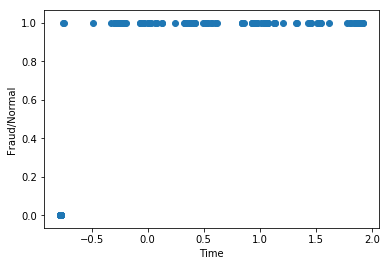

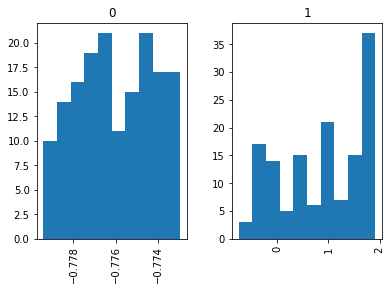

In [5]:
# Check if Fraud transactions appear at some specific Time
plt.scatter(data['Time'], data['Class'])
plt.xlabel('Time')
plt.ylabel('Fraud/Normal')

data['Time'].hist(by=data['Class'],bins=10)
plt.show()

#Conclusion - There seems to be strong pattern in the dataset. 
#Most of the Fraudelent transactions happen well after 1000 seconds or so.

## Split into Train & Test Data

In [6]:
from sklearn.model_selection import train_test_split

X = data.iloc[:,0:30]
y = data.iloc[:,-1]
trainX, testX, trainY, testY = train_test_split(X,y)

## Finding Important Features

    - One of the ways we can find important features for this dataset is to plot a HeatMap which would show corerelation between each feature

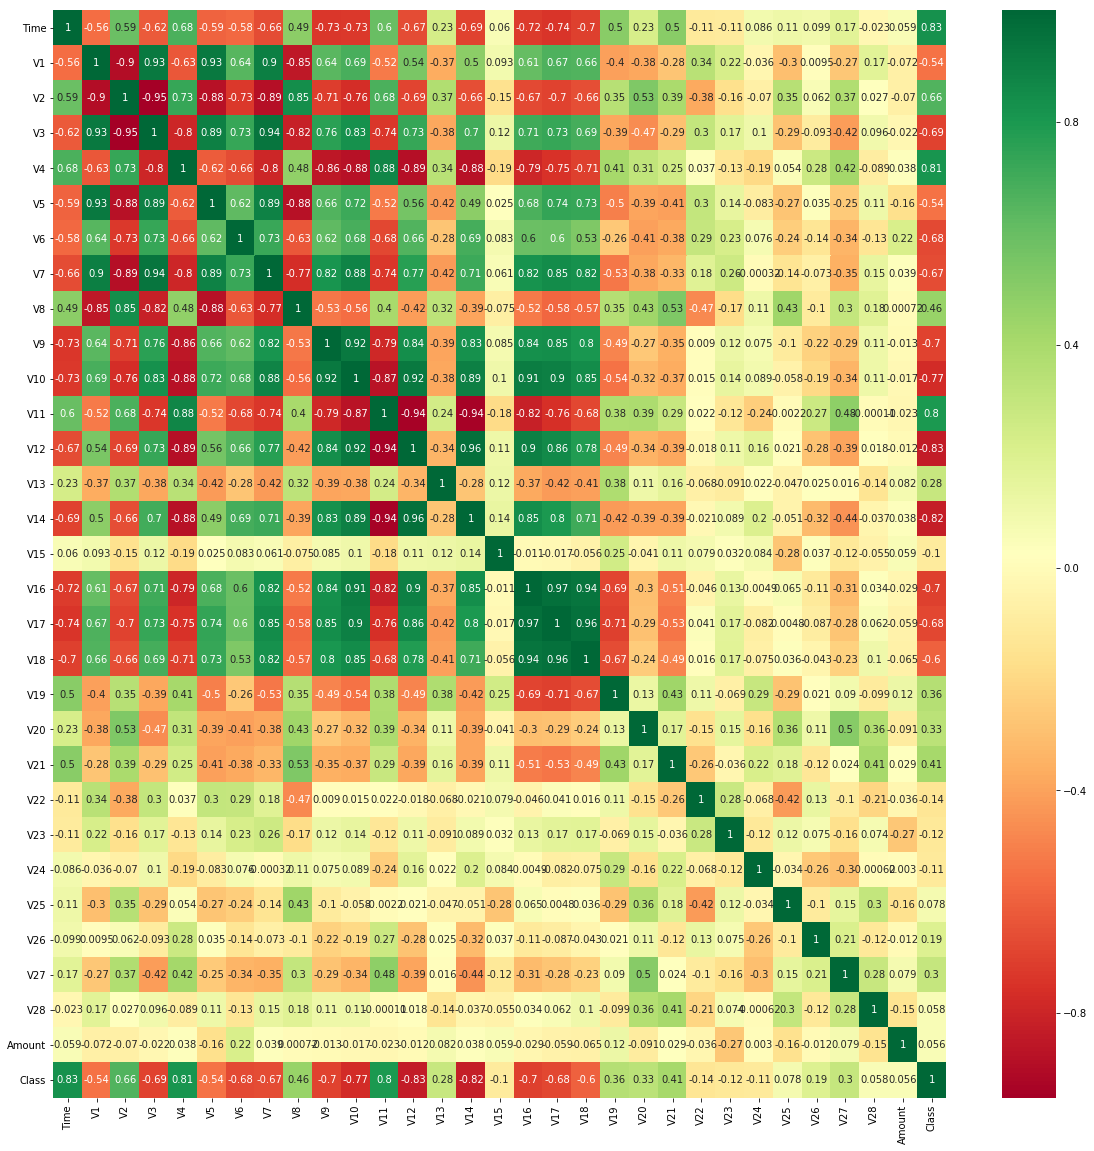

In [7]:
data_without_class = data.iloc[:,0:31]
corelation_matrix = data_without_class.corr()
top_corelation_features = corelation_matrix.index
plt.figure(figsize=(20,20))
g = sns.heatmap(data[top_corelation_features].corr(), annot=True, cmap='RdYlGn')

### Conclusion

    - We find that following features seem most relevant in identifying transaction as Fraud or Normal
        Time
        V4
        V11
        V2
        V8

# Identify & Plot Outliers in the dataset

    - I would be using PyOD which is a comprehensive and scalable Python toolkit for detecting outlying objects in multivariate data. See https://pyod.readthedocs.io/en/latest/# for details.
    
    Zhao, Y., Nasrullah, Z. and Li, Z., 2019. PyOD: A Python Toolbox for Scalable Outlier Detection. arXiv preprint arXiv:1901.01588.

#### Utility Functions for visualizing outliers

In [8]:
from mpl_toolkits.mplot3d.axes3d import Axes3D

def visualize_outliers(lofClassifier, trainX, training_scores):
    
    #For visualization we will pick the top three features.
    df = pd.DataFrame(data=list(zip(trainX['Time'],trainX['V4'],trainX['V11'])), columns=['Time','V4','V11'])
    df['anomaly_scores']=training_scores
    df['anomaly'] = (df['anomaly_scores'] >=lofClassifier.threshold_).astype(int)
    
    colors = {0:'blue', 1:'red'}
    fig = plt.figure(1, figsize=(7,7))
    ax = Axes3D(fig, rect=[0,0,0.95,1], elev=48, azim=134)
    ax.scatter(df['Time'],df['V4'],df['V11'], c= df['anomaly'].apply(lambda x: colors[x]), edgecolors='k')
    ax.set_xlabel('Time')
    ax.set_ylabel('V4')
    ax.set_zlabel('V11')
    plt.title('Outliers')
    plt.show()
    
    return df

In [17]:
from pyod.models.lof import LOF

total_tranx = data.shape[0]
fraud_tranx = data[data['Class']==1].shape[0]
contamination = fraud_tranx/total_tranx

# initialize model
lofClassifier = LOF (n_neighbors=20, algorithm='auto', metric='minkowski', contamination=contamination)

#train on training data
lofClassifier.fit(trainX)

LOF(algorithm='auto', contamination=0.46511627906976744, leaf_size=30,
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=20, p=2)

#### Visualize outliers on training data

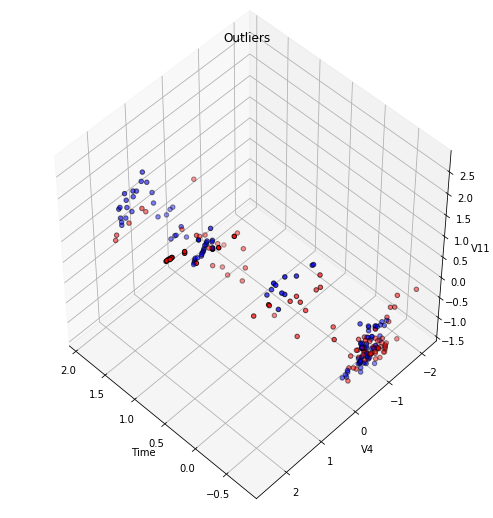

In [18]:
y_train_scores = lofClassifier.decision_scores_
training_anomaly_df = visualize_outliers(lofClassifier, trainX, y_train_scores)

#### Visualize outliers on testing data

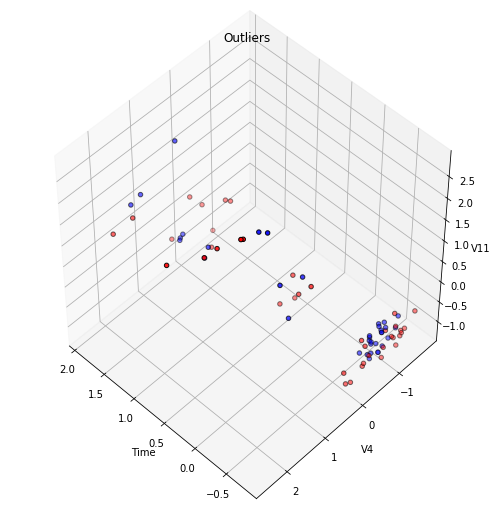

In [19]:
y_test_scores = lofClassifier.decision_function(testX)
testing_anomaly_df = visualize_outliers(lofClassifier, testX, y_test_scores)

#### Evaluate the fit of the model 

    - We would plot the anomaly score for normal and fraud transactions on the testing dataset; all fraud tranx should have a high anomaly score

In [20]:
def visualize_decision_scores (outliers, inliers):
    
    plt.hist(outliers['anomaly_scores'])
    plt.hist(inliers['anomaly_scores'])
    plt.legend(['Outliers','Inliers'])
    plt.xlabel('Anomaly Score')
    plt.ylabel('Count')
    plt.show()


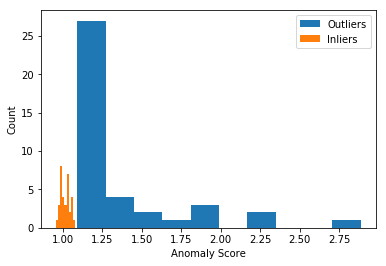

In [21]:
lof_outliers = testing_anomaly_df[testing_anomaly_df['anomaly']==1]
lof_inliers = testing_anomaly_df[testing_anomaly_df['anomaly']==0]
visualize_decision_scores(lof_outliers, lof_inliers)